In [7]:
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow xgboost plotly


Import thư viện

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from xgboost import XGBRegressor


Tải dữ liệu giá vàng quốc tế từ Yahoo Finance

In [13]:
gold = yf.download("GC=F", start="2000-01-01", end="2025-01-01")
gold.head()


/tmp/ipython-input-3585267057.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold = yf.download("GC=F", start="2000-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,0
2000-08-31,278.299988,278.299988,274.799988,274.799988,0
2000-09-01,277.000000,277.000000,277.000000,277.000000,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,2
2000-09-06,274.200012,274.200012,274.200012,274.200012,0


Chọn cột cần thiết và vẽ biểu đồ

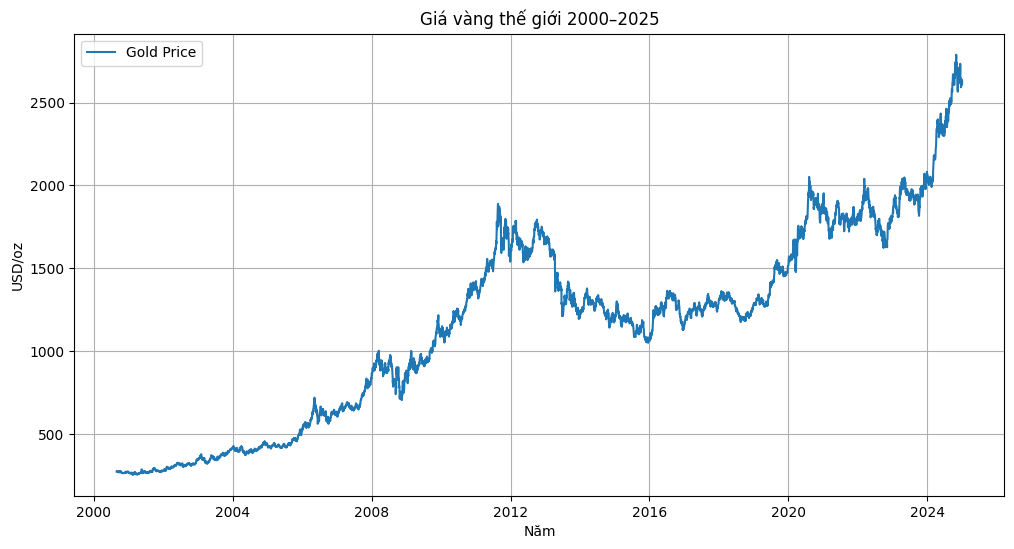

In [14]:
df = gold[["Close"]].copy()
df = df.dropna()

plt.figure(figsize=(12,6))
plt.plot(df["Close"], label="Gold Price")
plt.title("Giá vàng thế giới 2000–2025")
plt.xlabel("Năm")
plt.ylabel("USD/oz")
plt.grid(True)
plt.legend()
plt.show()


Tạo thêm đường trung bình động MA30

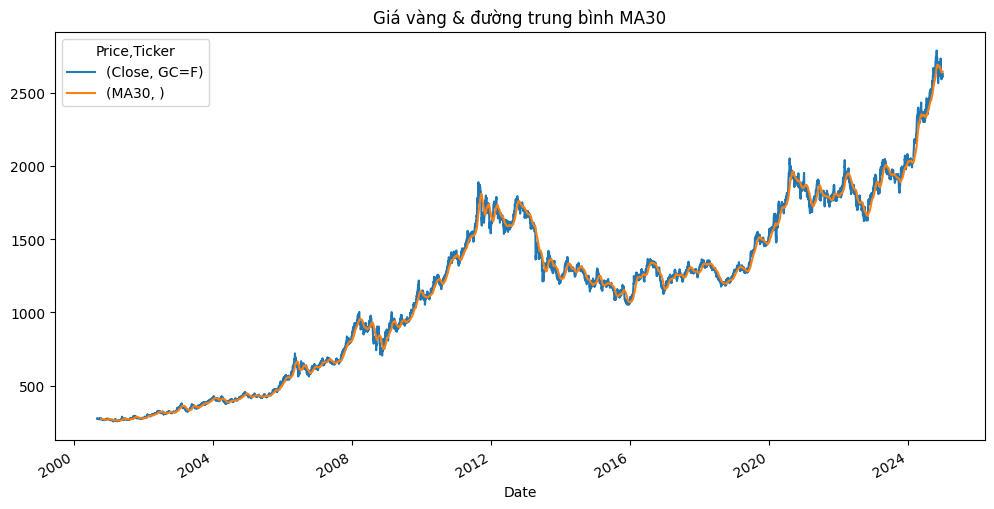

In [15]:
df["MA30"] = df["Close"].rolling(30).mean()

df[["Close", "MA30"]].plot(figsize=(12,6))
plt.title("Giá vàng & đường trung bình MA30")
plt.show()


Chuẩn hóa dữ liệu cho LSTM

In [16]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[["Close"]])


Tạo input chuỗi thời gian cho LSTM

In [17]:
X, y = [], []
lookback = 60

for i in range(lookback, len(scaled)):
    X.append(scaled[i-lookback:i, 0])
    y.append(scaled[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

X.shape, y.shape


((6046, 60, 1), (6046,))

Tạo mô hình LSTM

In [18]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Huấn luyện mô hình

In [19]:
history = model.fit(X, y, epochs=20, batch_size=32)


Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0136
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0017
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0014
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0012
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0012
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0010
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0010
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.3083e-04
Epoch 9/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0448e-04
Epoch 10/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7.3591e-04
Epoch 11/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.9890e-04
Epoch 12/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.7023e-04
Epoch 13/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.4589e-04
Epoch 14/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.5244e-04
Epoch 15/20
189/189 ━━━━

Dự báo 30 ngày tiếp theo

In [21]:
future = []
last_60 = scaled[-60:]

for _ in range(30):
    pred = model.predict(last_60.reshape(1,60,1))[0][0]
    future.append(pred)
    last_60 = np.append(last_60[1:], pred)

future_price = scaler.inverse_transform(np.array(future).reshape(-1,1))
future_price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━

array([[2641.592 ],
       [2643.6497],
       [2647.084 ],
       [2651.249 ],
       [2655.779 ],
       [2660.4712],
       [2665.2183],
       [2669.965 ],
       [2674.686 ],
       [2679.3718],
       [2684.0208],
       [2688.6343],
       [2693.2168],
       [2697.772 ],
       [2702.3032],
       [2706.8132],
       [2711.3047],
       [2715.7788],
       [2720.237 ],
       [2724.68  ],
       [2729.1077],
       [2733.5205],
       [2737.9185],
       [2742.3013],
       [2746.669 ],
       [2751.0208],
       [2755.3567],
       [2759.6763],
       [2763.9795],
       [2768.2659]], dtype=float32)

Vẽ biểu đồ dự báo

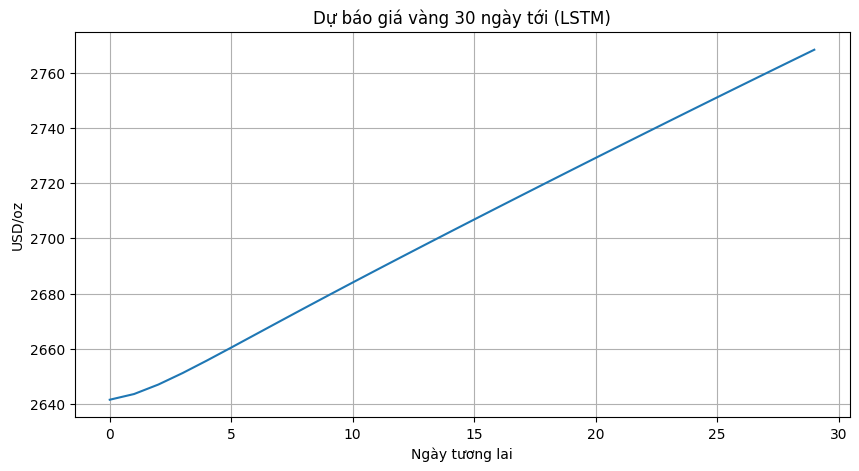

In [22]:
plt.figure(figsize=(10,5))
plt.plot(future_price)
plt.title("Dự báo giá vàng 30 ngày tới (LSTM)")
plt.xlabel("Ngày tương lai")
plt.ylabel("USD/oz")
plt.grid(True)
plt.show()


Mô hình XGBoost dự phòng

In [23]:
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05)

X2 = np.arange(len(df)).reshape(-1,1)
y2 = df["Close"].values

xgb.fit(X2, y2)

pred_xgb = xgb.predict(np.arange(len(df)+30).reshape(-1,1))
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05)

X2 = np.arange(len(df)).reshape(-1,1)
y2 = df["Close"].values

xgb.fit(X2, y2)

pred_xgb = xgb.predict(np.arange(len(df)+30).reshape(-1,1))


Biểu đồ so sánh LSTM vs XGBoost

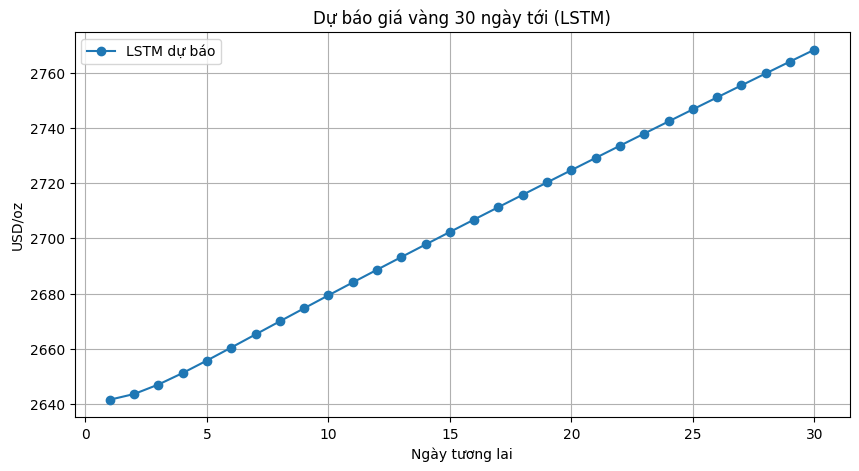

In [26]:
plt.figure(figsize=(10,5))
plt.plot(range(1,31), future_price.flatten(), marker='o', label="LSTM dự báo")
plt.xlabel("Ngày tương lai")
plt.ylabel("USD/oz")
plt.title("Dự báo giá vàng 30 ngày tới (LSTM)")
plt.legend()
plt.grid(True)
plt.show()


Đánh giá mô hình LSTM

In [27]:
pred_train = model.predict(X)

rmse = np.sqrt(mean_squared_error(y, pred_train))
mae = mean_absolute_error(y, pred_train)

print("RMSE:", rmse)
print("MAE:", mae)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE: 0.011747872358453385
MAE: 0.009334384086420297


In [28]:
plt.savefig("du_bao_gia_vang_30_ngay_LSTM.png", dpi=300)


<Figure size 640x480 with 0 Axes>